# Retrieving Titanium Oxides from The Materials Project

In [ ]:
import os
from mp_api.client import MPRester

api_key = ""

def write_xsf(structure, filename):
    with open(filename, "w") as f:
        f.write("CRYSTAL\n")
        f.write("PRIMVEC\n")
        for vec in structure.lattice.matrix:
            f.write(f"{vec[0]} {vec[1]} {vec[2]}\n")
        f.write("PRIMCOORD\n")
        f.write(f"{len(structure.sites)} 1\n")
        for site in structure.sites:
            f.write(f"{site.species_string} {site.x} {site.y} {site.z}\n")

# Create output dir
output_dir = "tioxides_xsf"
os.makedirs(output_dir, exist_ok=True)

with MPRester(api_key=api_key) as mpr:
    docs = mpr.materials.summary.search(
        elements=["Ti", "O"],
        num_elements=2,
        fields=["material_id", "formula_pretty", "structure"]
    )

    for doc in docs:
        structure = doc.structure
        formula = doc.formula_pretty.replace(" ", "")
        material_id = doc.material_id
        filename = os.path.join(output_dir, f"{formula}_{material_id}.xsf")
        write_xsf(structure, filename)

print(f"Saved {len(docs)} .xsf files to '{output_dir}/'")



Retrieving SummaryDoc documents:   0%|          | 0/124 [00:00<?, ?it/s]

Saved 124 .xsf files to 'tioxides_xsf/'


In [23]:
import os
import csv
from ase.io import read

def read_xsf_all_with_energy(directory):
    data = []

    metadata_path = os.path.join(directory, "metadata.csv")
    energy_lookup = {}

    with open(metadata_path, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            energy_lookup[row["filename"]] = float(row["energy_per_atom"])

    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".xsf") and filename in energy_lookup:
            atoms = read(os.path.join(directory, filename))
            energy_per_atom = energy_lookup[filename]
            data.append((atoms, energy_per_atom))

    return data


In [24]:
import numpy as np
import joblib
import matplotlib.pyplot as plt
from keras.models import load_model
from dscribe.descriptors import ACSF
from ase.io import read
from tqdm import tqdm
import os
import csv
from sklearn.metrics import mean_absolute_error

# Load models and scalers
best_model_g24 = load_model('best_acsf_model_g24_OPTIMAL.h5')
best_model_g2 = load_model('best_acsf_model_g2_OPTIMAL.h5')

x_scaler_g24 = joblib.load('X_scaler_g24.save')
y_scaler_g24 = joblib.load('y_scaler_g24.save')

x_scaler_g2 = joblib.load('X_scaler_g2.save')
y_scaler_g2 = joblib.load('y_scaler_g2.save')

# Prepare ACSF descriptors
r_cut = 6.0
R_s = np.linspace(0.0, r_cut, 12)
sigma = np.linspace(0.5, r_cut, 12)
eta = 1 / (2 * sigma**2)
g2_params = [[e, rs] for e in eta for rs in R_s]

eta = 1/(2 * sigma[1:]**2)
zeta = [1, 2, 4, 8, 16]
Lambda = [1, -1]
g4_params = [[e, z, l] for e in eta for z in zeta for l in Lambda]

species = ["Ti", "O"]
acsf = ACSF(
    species=species,
    r_cut=r_cut,
    g2_params=g2_params,
    g4_params=g4_params,
    periodic=True
)

# Function to featurize with both G2 and G4
def featurize_g24(atoms):
    return acsf.create(atoms).mean(axis=0)

# Function to featurize with only G2
def featurize_g2(atoms):
    acsf_g2 = ACSF(
        species=species,
        r_cut=r_cut,
        g2_params=g2_params,
        periodic=True
    )
    return acsf_g2.create(atoms).mean(axis=0)

# Function to read .xsf files and get energies
def read_xsf_all_with_energy(directory):
    data = []

    metadata_path = os.path.join(directory, "metadata.csv")
    energy_lookup = {}

    with open(metadata_path, "r") as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            energy_lookup[row["filename"]] = float(row["energy_per_atom"])

    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".xsf") and filename in energy_lookup:
            atoms = read(os.path.join(directory, filename))
            energy_per_atom = energy_lookup[filename]
            data.append((atoms, energy_per_atom))

    return data

2025-04-21 22:57:08.062968: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-04-21 22:57:08.063034: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-21 22:57:08.063041: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
I0000 00:00:1745301428.063466 2805362 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1745301428.063888 2805362 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [ ]:
# Read structures and energies
data = read_xsf_all_with_energy('tioxides_xsf')
atoms_list = [atoms for atoms, _ in data]
energies = np.array([energy for _, energy in data])

# Featurize with both G2 and G4 for model_g24
print("Featurizing with G2 + G4...")
features_g24 = np.array([featurize_g24(atoms) for atoms in tqdm(atoms_list)])

# Featurize with only G2 for model_g2
print("Featurizing with G2 only...")
features_g2 = np.array([featurize_g2(atoms) for atoms in tqdm(atoms_list)])

Featurizing with G2 + G4...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:36<00:00,  3.37it/s]


Featurizing with G2 only...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 124/124 [00:02<00:00, 60.49it/s]


In [ ]:
# Scale features using the appropriate scalers
print("Scaling features...")
features_g24_scaled = x_scaler_g24.transform(features_g24)
features_g2_scaled = x_scaler_g2.transform(features_g2)

# Predict using both models
print("Predicting with models...")
predictions_g24 = best_model_g24.predict(features_g24_scaled)
predictions_g2 = best_model_g2.predict(features_g2_scaled)

# Inverse transform predictions back to original scale
print("Inverse transforming predictions...")
predictions_g24 = y_scaler_g24.inverse_transform(predictions_g24)
predictions_g2 = y_scaler_g2.inverse_transform(predictions_g2)

Scaling features...
Predicting with models...
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


2025-04-21 22:57:48.259761: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Inverse transforming predictions...


In [ ]:
# Calculate evaluation metrics (e.g., Mean Absolute Error)
mae_g24 = mean_absolute_error(energies, predictions_g24)
mae_g2 = mean_absolute_error(energies, predictions_g2)

print(f"Mean Absolute Error (G2 + G4 model): {mae_g24:.4f}")
print(f"Mean Absolute Error (G2 model only): {mae_g2:.4f}")

Mean Absolute Error (G2 + G4 model): 843.8586
Mean Absolute Error (G2 model only): 846.5300


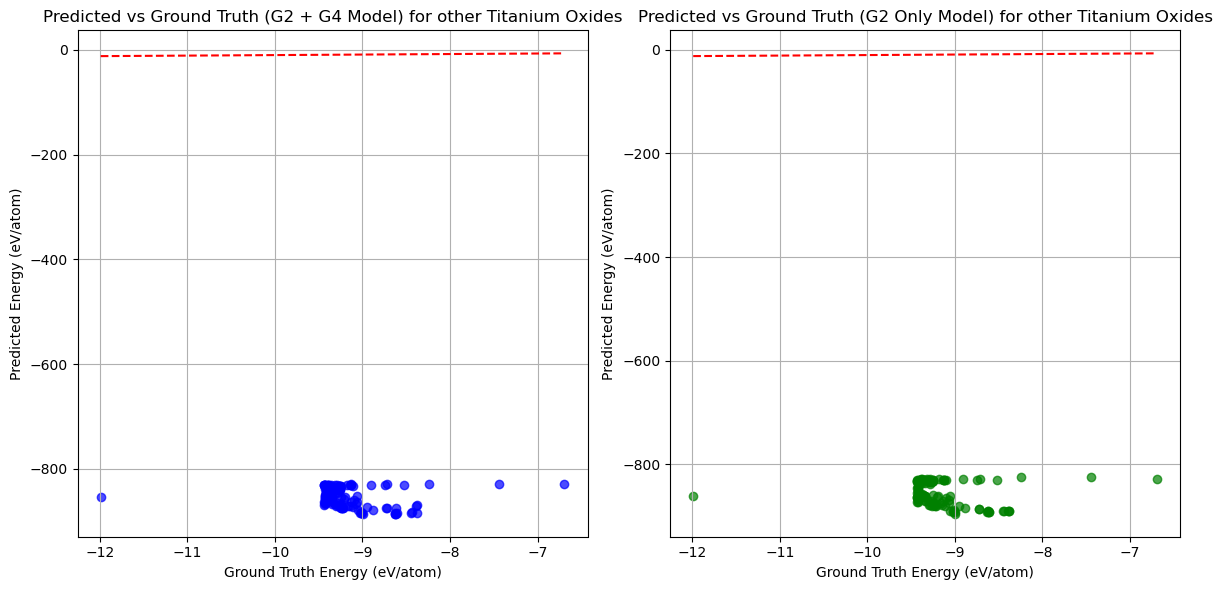

In [15]:
# Plotting predicted vs ground truth
plt.figure(figsize=(12, 6))

# Plot for G2 + G4 Model
plt.subplot(1, 2, 1)
plt.scatter(energies, predictions_g24, color='b', alpha=0.7)
plt.plot([min(energies), max(energies)], [min(energies), max(energies)], color='red', linestyle='--')
plt.title("Predicted vs Ground Truth (G2 + G4 Model) for other Titanium Oxides")
plt.xlabel("Ground Truth Energy (eV/atom)")
plt.ylabel("Predicted Energy (eV/atom)")
plt.grid(True)

# Plot for G2 Only Model
plt.subplot(1, 2, 2)
plt.scatter(energies, predictions_g2, color='g', alpha=0.7)
plt.plot([min(energies), max(energies)], [min(energies), max(energies)], color='red', linestyle='--')
plt.title("Predicted vs Ground Truth (G2 Only Model) for other Titanium Oxides")
plt.xlabel("Ground Truth Energy (eV/atom)")
plt.ylabel("Predicted Energy (eV/atom)")
plt.grid(True)

plt.tight_layout()
plt.show()

# Attempting to remove the offset

Average of predicted energies (G2 + G4 model): -853.0272216796875
Average of predicted energies (G2 only model): -855.6986694335938
Average of ground truth energies: -9.168667323544245
Detected energy offset for G2 + G4 model: 843.8585543561433
Detected energy offset for G2 only model: 846.5300021100495


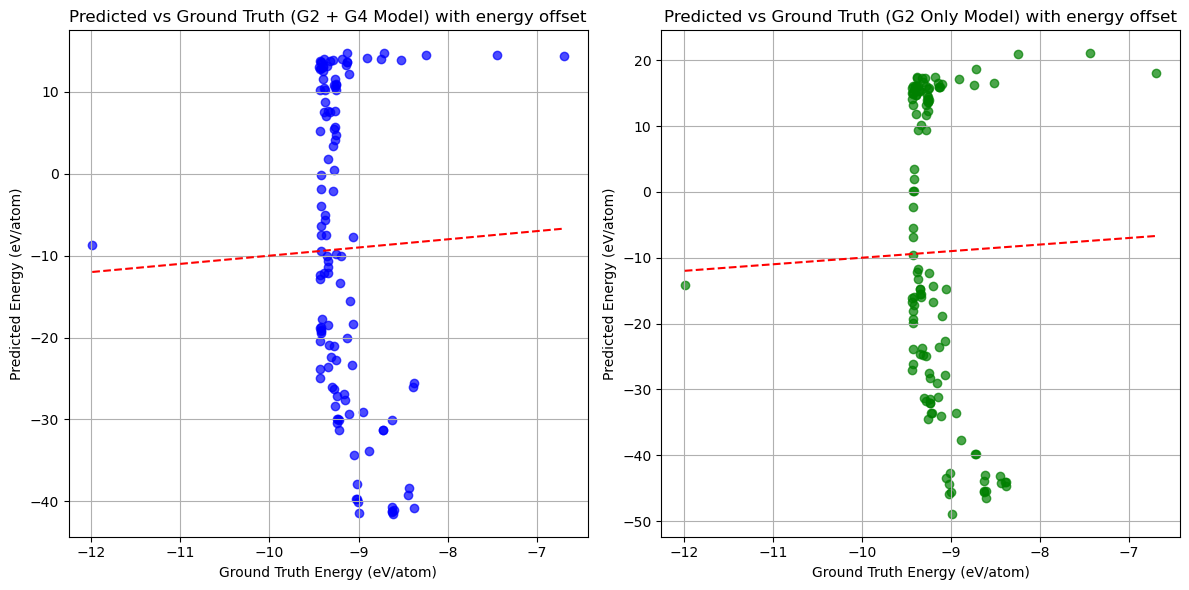

In [16]:
import numpy as np

# Load the original dataset
data = np.load("acsf_features_tio2_per_atom.npz")
y = data["y"]  # This is the true energy for the training set, in eV/atom

# Calculate the average of predicted and ground truth values
predicted_avg_g24 = np.mean(predictions_g24)
predicted_avg_g2 = np.mean(predictions_g2)
ground_truth_avg = np.mean(energies)

print(f"Average of predicted energies (G2 + G4 model): {predicted_avg_g24}")
print(f"Average of predicted energies (G2 only model): {predicted_avg_g2}")
print(f"Average of ground truth energies: {ground_truth_avg}")

# Check for any constant offset between the two models and ground truth
offset_g24 = ground_truth_avg - predicted_avg_g24
offset_g2 = ground_truth_avg - predicted_avg_g2

print(f"Detected energy offset for G2 + G4 model: {offset_g24}")
print(f"Detected energy offset for G2 only model: {offset_g2}")

# Adjust the predictions by the detected offsets
adjusted_predictions_g24 = predictions_g24 + offset_g24
adjusted_predictions_g2 = predictions_g2 + offset_g2

# Plotting predicted vs ground truth
plt.figure(figsize=(12, 6))

# Plot for G2 + G4 Model
plt.subplot(1, 2, 1)
plt.scatter(energies, adjusted_predictions_g24, color='b', alpha=0.7)
plt.plot([min(energies), max(energies)], [min(energies), max(energies)], color='red', linestyle='--')
plt.title("Predicted vs Ground Truth (G2 + G4 Model) with energy offset")
plt.xlabel("Ground Truth Energy (eV/atom)")
plt.ylabel("Predicted Energy (eV/atom)")
plt.grid(True)

# Plot for G2 Only Model
plt.subplot(1, 2, 2)
plt.scatter(energies, adjusted_predictions_g2, color='g', alpha=0.7)
plt.plot([min(energies), max(energies)], [min(energies), max(energies)], color='red', linestyle='--')
plt.title("Predicted vs Ground Truth (G2 Only Model) with energy offset")
plt.xlabel("Ground Truth Energy (eV/atom)")
plt.ylabel("Predicted Energy (eV/atom)")
plt.grid(True)

plt.tight_layout()
plt.show()


In [17]:
# MAE
mae_g24_adjusted = mean_absolute_error(energies, adjusted_predictions_g24)
mae_g2_adjusted = mean_absolute_error(energies, adjusted_predictions_g2)
print(f"Mean Absolute Error (G2 + G4 model, adjusted): {mae_g24_adjusted:.4f}")
print(f"Mean Absolute Error (G2 model only, adjusted): {mae_g2_adjusted:.4f}")

#RMSE
rmse_g24_adjusted = np.sqrt(np.mean((energies - adjusted_predictions_g24) ** 2))
rmse_g2_adjusted = np.sqrt(np.mean((energies - adjusted_predictions_g2) ** 2))
print(f"Root Mean Square Error (G2 + G4 model, adjusted): {rmse_g24_adjusted:.4f}")
print(f"Root Mean Square Error (G2 model only, adjusted): {rmse_g2_adjusted:.4f}")

Mean Absolute Error (G2 + G4 model, adjusted): 16.8865
Mean Absolute Error (G2 model only, adjusted): 21.0413
Root Mean Square Error (G2 + G4 model, adjusted): 18.8919
Root Mean Square Error (G2 model only, adjusted): 23.1158
